# Intro




The goal is to create a prototype of algorithm using Keras/tensorflow instead of fastai/pytorch. This will allow me to create my own model and to test those created by other teams.

---
The code is adapted from:

https://www.pyimagesearch.com/2017/12/11/image-classification-with-keras-and-deep-learning/

---
One uses the CovidX dataset from:

https://github.com/lindawangg/COVID-Net

---
Model copied from:

https://github.com/Goodsea/BreastNet/blob/master/40X/BreastNet_40X.ipynb

---


In [1]:
import tensorflow as tf
print('tf version : ' + tf.__version__)

tf version : 2.3.0


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


BEWARE: sometimes unziping does'nt work, and then the code won't run! It may be linked to the servers of google colab or the GPU that is automatically selected...

Check the number of files in the folder (compared to the csv file) and be sure that there are no errors during the process...

In [3]:
# Unzip CovidX-v4 dataset

# unzip Dr Arganda-Carreras's file:
# !unzip -q '/content/drive/My Drive/Colab Notebooks/Internship/COVID19_DATA/Covid-X-v4.zip'

# unzip mine (a copy of Dr Arganda-Carreras's file)
!unzip -q '/content/drive/My Drive/Colab Notebooks/Internship/COVIDX_models/Covid-X-v4.zip'

print('Done!')

Done!


We import data

In [4]:
import pathlib
path = pathlib.Path( '/content/data' )

# Parameters

# Model path
mod_path = '/content/drive/My Drive/Colab Notebooks/Internship/proto1'


# batch size
bs = 32

import pandas as pd
import numpy as np
import keras
from keras_preprocessing.image import ImageDataGenerator
import io

# Paths
path_train = pathlib.Path('/content/data/train/')
path_test = pathlib.Path('/content/data/test/')


# initialize the data and labels
data = []
labels = []

traindf= pd.read_csv(path/"train_split.txt", dtype=str, sep=' ', header=None, names=['Image','Name','Class','Origin']) #.drop('Origin',axis=1).drop('Image',axis=1)
testdf=pd.read_csv(path/"test_split.txt", dtype=str, sep=' ', header=None, names=['Image','Name','Class', 'Origin']) #.drop('Origin',axis=1).drop('Image',axis=1)
 


How is the csv file built?

In [5]:
traindf

,Image,Name,Class,Origin
0,3,SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0....,pneumonia,cohen
1,3,SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5....,pneumonia,cohen
2,3,SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10...,pneumonia,cohen
3,7,SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day...,pneumonia,cohen
4,7,SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day...,pneumonia,cohen
...,...,...,...,...
13887,c1628c47-5ba3-42dd-8df3-7ad3abd57ad0,c1628c47-5ba3-42dd-8df3-7ad3abd57ad0.png,pneumonia,rsna
13888,c1cddf32-b957-4753-acaa-472ab1447e86,c1cddf32-b957-4753-acaa-472ab1447e86.png,pneumonia,rsna
13889,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2.png,pneumonia,rsna
13890,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8.png,pneumonia,rsna


Now, we create our generator, we create three generator: train, valid and test.

In [15]:
# OPTION 1
# datagen=ImageDataGenerator(validation_split=0.25) # We split the set

# OPTION 2
# Let's try to augment data : (tuto : https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/)
datagen = ImageDataGenerator(rescale=1./255,
                                validation_split=0.25,
                                rotation_range=30,
	                              zoom_range=0.15,
	                              width_shift_range=0.2,
	                              height_shift_range=0.2,
	                              shear_range=0.15,
	                              horizontal_flip=True,
	                              fill_mode="nearest")


size = 224 # Size of the images

train_generator=datagen.flow_from_dataframe(
  dataframe=traindf,
  directory=path_train,
  x_col='Name',
  y_col='Class',
  subset='training',
  batch_size=bs,
  seed=42,
  shuffle=True,
  class_mode="categorical",
  target_size=(size,size))

valid_generator=datagen.flow_from_dataframe(
  dataframe=traindf,
  directory=path_train,
  x_col='Name',
  y_col='Class',
  subset='validation',
  batch_size=bs,
  seed=42,
  shuffle=True,
  class_mode="categorical",
  target_size=(size,size))

test_datagen=ImageDataGenerator(rescale=1./255)

test_generator=test_datagen.flow_from_dataframe(
  dataframe=testdf,
  directory=path_test,
  x_col='Name',
  y_col=None,
  batch_size=bs,
  shuffle=False, #DO NOT SHUFFLE, otherwise you won't be able to calculate monitors afterward 
  class_mode=None,
  target_size=(size,size))



Found 10419 validated image filenames belonging to 3 classes.
Found 3473 validated image filenames belonging to 3 classes.
Found 1579 validated image filenames.


In [16]:
train_generator[100]

(array([[[[0.1137255 , 0.1137255 , 0.1137255 ],
          [0.1137255 , 0.1137255 , 0.1137255 ],
          [0.1137255 , 0.1137255 , 0.1137255 ],
          ...,
          [0.17202805, 0.17202805, 0.17202805],
          [0.227451  , 0.227451  , 0.227451  ],
          [0.227451  , 0.227451  , 0.227451  ]],
 
         [[0.1137255 , 0.1137255 , 0.1137255 ],
          [0.1137255 , 0.1137255 , 0.1137255 ],
          [0.1137255 , 0.1137255 , 0.1137255 ],
          ...,
          [0.17828055, 0.17828055, 0.17828055],
          [0.227451  , 0.227451  , 0.227451  ],
          [0.227451  , 0.227451  , 0.227451  ]],
 
         [[0.1137255 , 0.1137255 , 0.1137255 ],
          [0.1137255 , 0.1137255 , 0.1137255 ],
          [0.1137255 , 0.1137255 , 0.1137255 ],
          ...,
          [0.18453306, 0.18453306, 0.18453306],
          [0.227451  , 0.227451  , 0.227451  ],
          [0.227451  , 0.227451  , 0.227451  ]],
 
         ...,
 
         [[0.752267  , 0.752267  , 0.752267  ],
          [0.74758

The indices of each class:

In [17]:
print(train_generator.class_indices)

{'COVID-19': 0, 'normal': 1, 'pneumonia': 2}


Our dataset is unbalanced: so we solve it by using class_weights.

In [18]:
from collections import Counter
labels_count = Counter()

for word in traindf['Class']:
  labels_count[word] += 1

total_count = sum(labels_count.values())
class_weights = {cls: total_count / count for cls, count in labels_count.items()}



How much images for each classes in the train generator:

In [19]:
labels_count

Counter({'COVID-19': 468, 'normal': 7966, 'pneumonia': 5458})

The less images we have for one class, the heavier it is:

In [20]:
class_weights

{'COVID-19': 29.683760683760685,
 'normal': 1.7439116244037158,
 'pneumonia': 2.5452546720410405}

We use indices instead of class names:

In [21]:
class_weights[train_generator.class_indices['COVID-19']] = class_weights.pop('COVID-19')
class_weights[train_generator.class_indices['normal']] = class_weights.pop('normal')
class_weights[train_generator.class_indices['pneumonia']] = class_weights.pop('pneumonia')

New dictionary:

In [22]:
class_weights

{0: 29.683760683760685, 1: 1.7439116244037158, 2: 2.5452546720410405}

In [23]:
from keras.models import Sequential, save_model, load_model
from keras import regularizers, optimizers, Model

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.callbacks import *

import logging

logging.getLogger('tensorflow').setLevel(logging.ERROR)


class CosineAnnealer:
    
    def __init__(self, start, end, steps):
        self.start = start
        self.end = end
        self.steps = steps
        self.n = 0
        
    def step(self):
        self.n += 1
        cos = np.cos(np.pi * (self.n / self.steps)) + 1
        return self.end + (self.start - self.end) / 2. * cos


class OneCycleScheduler(Callback):
    """`Callback` that schedules the learning rate on a 1cycle policy as per Leslie Smith's paper(https://arxiv.org/pdf/1803.09820.pdf).
    If the model supports a momentum parameter, it will also be adapted by the schedule.
    The implementation adopts additional improvements as per the fastai library: https://docs.fast.ai/callbacks.one_cycle.html, where
    only two phases are used and the adaptation is done using cosine annealing.
    In phase 1 the LR increases from `lr_max / div_factor` to `lr_max` and momentum decreases from `mom_max` to `mom_min`.
    In the second phase the LR decreases from `lr_max` to `lr_max / (div_factor * 1e4)` and momemtum from `mom_max` to `mom_min`.
    By default the phases are not of equal length, with the phase 1 percentage controlled by the parameter `phase_1_pct`.
    """

    def __init__(self, lr_max, steps, mom_min=0.85, mom_max=0.95, phase_1_pct=0.3, div_factor=25.):
        super(OneCycleScheduler, self).__init__()
        lr_min = lr_max / div_factor
        final_lr = lr_max / (div_factor * 1e4)
        phase_1_steps = steps * phase_1_pct
        phase_2_steps = steps - phase_1_steps
        
        self.phase_1_steps = phase_1_steps
        self.phase_2_steps = phase_2_steps
        self.phase = 0
        self.step = 0
        
        self.phases = [[CosineAnnealer(lr_min, lr_max, phase_1_steps), CosineAnnealer(mom_max, mom_min, phase_1_steps)], 
                 [CosineAnnealer(lr_max, final_lr, phase_2_steps), CosineAnnealer(mom_min, mom_max, phase_2_steps)]]
        
        self.lrs = []
        self.moms = []

    def on_train_begin(self, logs=None):
        self.phase = 0
        self.step = 0

        self.set_lr(self.lr_schedule().start)
        self.set_momentum(self.mom_schedule().start)
        
    def on_train_batch_begin(self, batch, logs=None):
        self.lrs.append(self.get_lr())
        self.moms.append(self.get_momentum())

    def on_train_batch_end(self, batch, logs=None):
        self.step += 1
        if self.step >= self.phase_1_steps:
            self.phase = 1
            
        self.set_lr(self.lr_schedule().step())
        self.set_momentum(self.mom_schedule().step())
        
    def get_lr(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.lr)
        except AttributeError:
            return None
        
    def get_momentum(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.momentum)
        except AttributeError:
            return None
        
    def set_lr(self, lr):
        try:
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        except AttributeError:
            pass # ignore
        
    def set_momentum(self, mom):
        try:
            tf.keras.backend.set_value(self.model.optimizer.momentum, mom)
        except AttributeError:
            pass # ignore

    def lr_schedule(self):
        return self.phases[self.phase][0]
    
    def mom_schedule(self):
        return self.phases[self.phase][1]
    
    def plot(self):
        ax = plt.subplot(1, 2, 1)
        ax.plot(self.lrs)
        ax.set_title('Learning Rate')
        ax = plt.subplot(1, 2, 2)
        ax.plot(self.moms)
        ax.set_title('Momentum')


class LRFinder(Callback):
    """`Callback` that exponentially adjusts the learning rate after each training batch between `start_lr` and
    `end_lr` for a maximum number of batches: `max_step`. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the `plot` method.
    """

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10, max_steps: int = 1000, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

     

In [24]:
# copied from https://github.com/kobiso/CBAM-keras/blob/master/models/attention_module.py
# used for Breastnet model : https://github.com/Goodsea/BreastNet/blob/master/40X/BreastNet_40X.ipynb adapted for keras

from keras.layers import *
from keras.optimizers import *
from keras.models import load_model, Model

from keras import backend as K
SHAPE = (224, 224, 3)
from keras.layers import Input

def cbam_block(cbam_feature, ratio=8):
    """Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521.
    """
    
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

def channel_attention(input_feature, ratio=8):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature._shape[channel_axis] #change _keras_shape into _shape
    
    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    
    avg_pool = GlobalAveragePooling2D()(input_feature)    
    avg_pool = Reshape((1,1,channel))(avg_pool)
    assert avg_pool._shape[1:] == (1,1,channel) #_keras
    avg_pool = shared_layer_one(avg_pool)
    assert avg_pool._shape[1:] == (1,1,channel//ratio) #_keras
    avg_pool = shared_layer_two(avg_pool)
    assert avg_pool._shape[1:] == (1,1,channel) #_keras
    
    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1,1,channel))(max_pool)
    assert max_pool._shape[1:] == (1,1,channel) #_keras
    max_pool = shared_layer_one(max_pool)
    assert max_pool._shape[1:] == (1,1,channel//ratio) #_keras
    max_pool = shared_layer_two(max_pool)
    assert max_pool._shape[1:] == (1,1,channel) #_keras
    
    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
    
    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    
    if K.image_data_format() == "channels_first":
        channel = input_feature._shape[1] #_keras
        cbam_feature = Permute((2,3,1))(input_feature)
    else:
        channel = input_feature._shape[-1] #_keras_
        cbam_feature = input_feature
    
    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool._shape[-1] == 1 #_keras
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool._shape[-1] == 1 #_keras
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat._shape[-1] == 2 #_keras
    cbam_feature = Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)(concat)	
    assert cbam_feature._shape[-1] == 1 #_keras
    
    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
        
    return multiply([input_feature, cbam_feature])

Metrics:

In [25]:

# credits: https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras

def recall(y_true, y_pred):
    """
    Recall metric.
    
    Only computes a batch-wise average of recall.
    
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    """Precision metric.
    
    Only computes a batch-wise average of precision.
    
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precisionx = precision(y_true, y_pred)
    recallx = recall(y_true, y_pred)
    return 2*((precisionx*recallx)/(precisionx+recallx+K.epsilon()))

In [26]:
# copied from https://gist.github.com/mjdietzx/5319e42637ed7ef095d430cb5c5e8c64
def residual_block(y, nb_channels, _strides=(1, 1), _project_shortcut=False):
    shortcut = y

    # down-sampling is performed with a stride of 2
    y = Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
    y = BatchNormalization()(y)
    y = LeakyReLU()(y)

    y = Conv2D(nb_channels, kernel_size=(3, 3), strides=(1, 1), padding='same')(y)
    y = BatchNormalization()(y)

    # identity shortcuts used directly when the input and output are of the same dimensions
    if _project_shortcut or _strides != (1, 1):
        # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
        # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
        shortcut = Conv2D(nb_channels, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    y = add([shortcut, y])
    y = LeakyReLU()(y)

    return y



In [27]:
# copied from https://github.com/Goodsea/BreastNet/blob/master/40X/BreastNet_40X.ipynb, "create_model()"

def Breastnet_model():
    
    dropRate = 0.3
    
    init = Input(SHAPE)
    x = Conv2D(32, (3, 3), activation=None, padding='same')(init) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), activation=None, padding='same')(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x1 = MaxPooling2D((2,2))(x)
    
    x = Conv2D(64, (3, 3), activation=None, padding='same')(x1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = cbam_block(x)
    x = residual_block(x, 64)
    x2 = MaxPooling2D((2,2))(x)
    
    x = Conv2D(128, (3, 3), activation=None, padding='same')(x2)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = cbam_block(x)
    x = residual_block(x, 128)
    x3 = MaxPooling2D((2,2))(x)
    
    ginp1 = UpSampling2D(size=(2, 2), interpolation='bilinear')(x1)
    ginp2 = UpSampling2D(size=(4, 4), interpolation='bilinear')(x2)
    ginp3 = UpSampling2D(size=(8, 8), interpolation='bilinear')(x3)
    
    hypercolumn = Concatenate()([ginp1, ginp2, ginp3]) 
    gap = GlobalAveragePooling2D()(hypercolumn)

    x = Dense(256, activation=None)(gap)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropRate)(x)
    
    x = Dense(256, activation=None)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    y = Dense(3, activation='softmax')(x) # modified it for 3 classes 
   
    model = Model(init, y)
    return model

Let's try to fix overfitting by modifying the model

In [28]:
# copied from https://github.com/Goodsea/BreastNet/blob/master/40X/BreastNet_40X.ipynb, "create_model()"

# We adapt this model by adding some dropout layers to counter overfitting
def Breastnet_modified_model():
    
    dropRate = 0.3
    
    init = Input(SHAPE)
    x = Conv2D(32, (3, 3), activation=None, padding='same')(init) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropRate)(x) # adding dropout
    x = Conv2D(32, (3, 3), activation=None, padding='same')(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropRate)(x) # adding dropout
    x1 = MaxPooling2D((2,2))(x)
    
    x = Conv2D(64, (3, 3), activation=None, padding='same')(x1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropRate)(x) # adding dropout
    x = cbam_block(x)
    x = residual_block(x, 64)
    x2 = MaxPooling2D((2,2))(x)
    
    x = Conv2D(128, (3, 3), activation=None, padding='same')(x2)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropRate)(x) # adding dropout
    x = cbam_block(x)
    x = residual_block(x, 128)
    x3 = MaxPooling2D((2,2))(x)
    
    ginp1 = UpSampling2D(size=(2, 2), interpolation='bilinear')(x1)
    ginp2 = UpSampling2D(size=(4, 4), interpolation='bilinear')(x2)
    ginp3 = UpSampling2D(size=(8, 8), interpolation='bilinear')(x3)
    
    hypercolumn = Concatenate()([ginp1, ginp2, ginp3]) 
    gap = GlobalAveragePooling2D()(hypercolumn)

    x = Dense(256, activation=None)(gap)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropRate)(x) # this one was already in the original model
    
    x = Dense(256, activation=None)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    y = Dense(3, activation='softmax')(x) # modified it for 3 classes 
   
    model = Model(init, y)
    return model

In [29]:
# CLR parameters
lr = 1e-3
epochs = 20

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

steps = STEP_SIZE_TRAIN * epochs

lr_schedule = OneCycleScheduler(lr, steps)

base_model = Breastnet_modified_model()

optimizer = tf.keras.optimizers.Adam(lr=lr)

# optimizer = tf.keras.optimizers.Adam(amsgrad=True)
base_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= [precision, recall, f1, 'accuracy']) #, weighted_metrics = class_weights)

base_model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
# lr_finder = LRFinder(max_steps=500)

# History = base_model.fit_generator(generator=train_generator,
#                     steps_per_epoch=STEP_SIZE_TRAIN,
#                     validation_data=valid_generator,
#                     validation_steps=STEP_SIZE_VALID,
#                     class_weight=class_weights, # We change the weights
#                     epochs=epochs,
#                     callbacks=[lr_finder],
#                     workers=4
#                     verbose = 2)

# import matplotlib.pyplot as plt

# lr_finder.plot()

In [30]:

checkpoint_filepath = 'model_check_breastnet'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False)


History = base_model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    class_weight=class_weights, # We change the weights
                    epochs=epochs,
                    callbacks=[checkpoint_callback, lr_schedule],
                    workers=4,
                    verbose = 2)

Epoch 1/20

Epoch 00001: val_loss improved from inf to 4.27666, saving model to model_check_breastnet
325/325 - 327s - loss: 1.9244 - precision: 0.6525 - recall: 0.5216 - f1: 0.5775 - accuracy: 0.6116 - val_loss: 4.2767 - val_precision: 0.0101 - val_recall: 0.0101 - val_f1: 0.0101 - val_accuracy: 0.0101
Epoch 2/20

Epoch 00002: val_loss improved from 4.27666 to 1.72795, saving model to model_check_breastnet
325/325 - 316s - loss: 1.1708 - precision: 0.7614 - recall: 0.7380 - f1: 0.7492 - accuracy: 0.7549 - val_loss: 1.7279 - val_precision: 0.3537 - val_recall: 0.3464 - val_f1: 0.3499 - val_accuracy: 0.3573
Epoch 3/20

Epoch 00003: val_loss improved from 1.72795 to 0.89369, saving model to model_check_breastnet
325/325 - 312s - loss: 1.0085 - precision: 0.7826 - recall: 0.7783 - f1: 0.7804 - accuracy: 0.7806 - val_loss: 0.8937 - val_precision: 0.7989 - val_recall: 0.7870 - val_f1: 0.7928 - val_accuracy: 0.7922
Epoch 4/20

Epoch 00004: val_loss did not improve from 0.89369
325/325 - 307s

In [31]:
print(History.history.keys())

dict_keys(['loss', 'precision', 'recall', 'f1', 'accuracy', 'val_loss', 'val_precision', 'val_recall', 'val_f1', 'val_accuracy'])


# Test

Now we compute all the required metrics

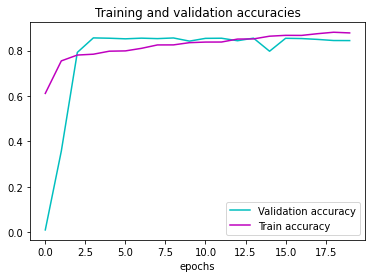

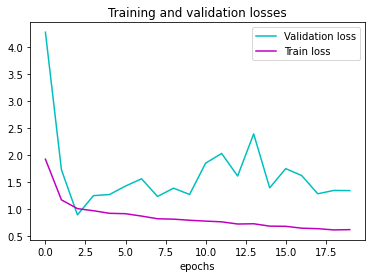

In [32]:
# Plot Learning Rate
import matplotlib.pyplot as plt


# Plot losses
val_accuracy = History.history['val_accuracy']
acc = History.history['accuracy']
plt.plot(range(len(val_accuracy)),val_accuracy,'c',label='Validation accuracy')
plt.plot(range(len(acc)),acc,'m',label='Train accuracy')
plt.title('Training and validation accuracies')
plt.legend()
plt.xlabel('epochs')
plt.show()

# Plot losses
val_loss = History.history['val_loss']
loss = History.history['loss']
plt.plot(range(len(val_loss)),val_loss,'c',label='Validation loss')
plt.plot(range(len(loss)),loss,'m',label='Train loss')
plt.title('Training and validation losses')
plt.legend()
plt.xlabel('epochs')
plt.show()


It's time to use our test dataset!

In [33]:
model = load_model(checkpoint_filepath, custom_objects={'f1': f1, 'precision': precision, 'recall': recall})

KeyboardInterrupt: ignored

In [34]:
# Generate predictions for samples
predictions = base_model.predict(test_generator)
print(predictions)

[[2.9609052e-06 9.6754706e-01 3.2449923e-02]
 [7.9394912e-04 7.7065772e-01 2.2854835e-01]
 [9.5554307e-04 7.4543113e-01 2.5361335e-01]
 ...
 [6.2311545e-04 2.9289407e-01 7.0648283e-01]
 [4.6590864e-04 8.4544086e-01 1.5409325e-01]
 [7.9042447e-04 3.6567384e-01 6.3353568e-01]]


In [35]:
import numpy as np
class_guess = np.argmax(predictions, axis=1)


In [36]:
label_map = (train_generator.class_indices)
print(label_map)

{'COVID-19': 0, 'normal': 1, 'pneumonia': 2}


In [37]:
# adapted from COVIDX-Fastai-XResNet18.ipynb
# Convert dataframe test labels to list
gt = testdf['Class'].tolist()

# Convert from label names to class index values (0, 1, 2)
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
labels = ['COVID-19', 'normal', 'pneumonia']
le = preprocessing.LabelEncoder()
targets = le.fit_transform(labels)
test_preds = le.transform( gt )

print("Size of class_guess : " + str(np.size(class_guess)))
print("Size of test_preds : " + str(np.size(np.asarray( test_preds ))))
print("class_guess : " + str(class_guess))
print("test_preds : " + str(test_preds))

# Calculate accuracy
from sklearn.metrics import accuracy_score
acc = accuracy_score( class_guess, np.asarray( test_preds ) )
print( "Accuracy = " + str( acc ) )

# Calculate precision per class
print(labels)

from sklearn.metrics import precision_score
prec = precision_score( class_guess, np.asarray( test_preds ), average=None )
print( "Precision (Positive Predictive Value) per class = " + str( prec ))

# Calculate recall per class
from sklearn.metrics import recall_score
rec = recall_score(class_guess, np.asarray(test_preds), average=None )
print( "Recall (Sensitiviy) per class = " + str( rec ))


print('Confusion Matrix')
print(confusion_matrix(np.asarray( test_preds ), class_guess))

Size of class_guess : 1579
Size of test_preds : 1579
class_guess : [1 1 1 ... 2 1 2]
test_preds : [2 2 2 ... 2 2 2]
Accuracy = 0.7118429385687144
['COVID-19', 'normal', 'pneumonia']
Precision (Positive Predictive Value) per class = [0.         0.99096045 0.41582492]
Recall (Sensitiviy) per class = [0.         0.67461538 0.88530466]
Confusion Matrix
[[  0  76  24]
 [  0 877   8]
 [  0 347 247]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
